# ML-Fundamentals - Decision Trees

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge) 
  * [Modules](#Python-Modules)
* [Teaching Content](#Teaching-Content)
 * [Decision Trees](#Decision-Trees)
 * [Learning](#Learning)
 * [Information Gain as Splitting Criterion](#Information-Gain-as-Splitting-Criterion)
 * [Overfitting](#Overfitting)
* [Exercises](#Exercises)
 * [Loading the Data](#Loading-the-Data)
 * [Preprocessing](#Preprocessing)
 * [Training and Visualization](#Training-and-Visualization)
 * [Prediction / Validation](#Prediction-/-Validation)
 * [Crossvalidation](#Crossvalidation)
 * [Gridsearch](#Gridsearch)
 * [Splitting Criterion Entropy / Information Gain](#Splitting-Criterion-Entropy-/-Information-Gain)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature) 
* [Licenses](#Licenses)

## Introduction

In this exercise you will train and evaluate a decision tree. Opposed to the previous exercises with the topics _univariate linear regression_, _multivariate linear regression_, _logistic regression_ and _bias variance tradeoff_, you will not implement the algorithms from scratch using numpy. Instead you will use two python packages written on top of numpy, namely the _pandas_ and the _scikit-learn_ package, which are both widely used by the machine learning community. The steps can be broken down into:

1. Load the data from a _csv file_ into a pandas DataFrame object
2. Preprocess the data
3. Train a decision tree and visualize it.
4. Do hyperparameter optimization by dividing the dataset into a fixed training set and a fixed validation set.
5. Do hyperparameter optimization by crossvalidation
6. Do hyperparameter optimization by gridsearch

Afterwards, show that you understand, what computations are done by the _scikit-learn_ package you have used by manually computing:

7. The entropy for one node
8. The information gain for one node

**Note:**

As this exercise heavily focuses on the usage of the high-level APIs _pandas_ and _scikit-learn_, reading their documentations (just the parts corresponding to the current task) is strongly recommended:

- https://scikit-learn.org/stable/documentation.html#
- https://pandas.pydata.org/pandas-docs/stable/search.html?q=&check_keywords=yes&area=default

## Requirements
### Knowledge

You should have a basic knowledge of:
- Decision Trees
- Entropy
- Information gain
- Crossvalidation

### Python Modules

By [deep.TEACHING](https://www.deep-teaching.org/) convention, all python modules needed to run the notebook are loaded centrally at the beginning. 


In [1]:
import numpy as np
import pandas as pd
import math

#from sklearn.preprocessing import Imputer # in newer versions: 
from sklearn.impute import SimpleImputer as Imputer

from sklearn import tree

#old: from sklearn.externals.six import StringIO
from six import StringIO

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from graphviz import Source

## Teaching Content

### Decision Trees for Classification

In a decision tree the data is split at each node according to a decision rule. This corresponds to nested *if-then-else*-rules. In the *if*-part of such a rule are decision is made based on a feature of the data record. 

We will use the scikit learn implementation. For this implementation the features must be binary or have (at least) ordinal characteristic. If a feature is e.g. nominal with many values, it must be converted to a set of binary (one-hot-coded) features.


The splitting rules in the scikit learn implementation are binary and are based on a threshold, e.g.
  - _if $x_6 <= 2.14$ then_ left subbranch, *else* right subbranch.         
  - binary features must be coded as 0/1, so the rule becomes: if $x_2 <= 0.5$ _then_ left subbranch, _else_ right subbranch. 


<!--The structure of the tree will be determined by data (see below) and a training procedure.-->

In the leaves of the tree the (class) predictions are made. There are two possibilities for such an inference: 
   - hard assignment: Predict for the data records which end up on a leaf by the majority class of the training data that end up on that leaf.          
   - soft assignment: Assign probabilities according to the distribution of the classes in respect to the training data which end up on that leaf.

As an example of a decision tree we will learn the following tree from the titanic data set: 

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/klaus/exercise-decision-trees-a-tree.png" width="1024" alt="internet connection needed">

A full explanation of the tree will be given later. Here just look at the decision rules (first line of the inner nodes) and at the last line of the leafs. In each leaf you see an array (values) with counts of the different targets for the train data: [number_died, number_survivors] .

### Learning 

Finding a tree that splits the training data optimal is [np-hard](https://en.wikipedia.org/wiki/NP-hardness). Therefore often a *greedy*-strategy is used:

To build up a decision tree the algorithm starts at the root of the tree. The feature and the threshold 
that splits the training data best (with respect to the classes) are chosen. In an iterative way the whole tree is build up by such splitting rules. 

There are different criteria for measuring the "separation (split) quality". The most important ones are:

- Gini Impurity 
- Information Gain 

In this tutorial we concentrate on the information gain.

### Information Gain as Splitting Criterion

The entropy with respect to the target class variable $y$ of a training data set $\mathcal D$ is defined as:

$$
 H(y, \mathcal D) = - \sum_{y \in \mathcal Y} p(y|\mathcal D) \log_2 p(y|\mathcal D)
$$
with the domain of the target values $\mathcal Y = \{t_1, t_2,... \}$.


The probabilities are estimated by 
$$
  p(y=t_i, \mathcal D) = |\mathcal D^{(y=t_i)}| /|\mathcal D| 
$$    


with the number of training data $|\mathcal D|$  and the number of training data $|\mathcal D^{(y=t_i)}|$ with target label $t_i$: 


On a node a (binary) split on a feature $x_k$ is made by the split rule $x_k \leq v$. 
As result there are two data sets $\mathcal D_0$ and $\mathcal D_1$ for the left resp. the right branch.

The feature $x_k$ and the split value $v$ are chosen that they maximize the 'reduction of the entropy' measured by the information gain $I$:
$$
  I(y; x_k) = H(y, \mathcal D) - H(y|x_k) = H(y, \mathcal D) - \sum_{j=0}^1 p_jH(y, \mathcal D_j) =
  H(y, \mathcal D) + \sum_{j=0}^1  \sum_{y \in \mathcal Y} \frac{|\mathcal D_j|}{|\mathcal D|} p(y|\mathcal D_j) \log_2 p(y|\mathcal D_j)
$$
Note that $p_{j=0}$  is the estimated probability that a random data record of $\mathcal D$ has feature value $x_k \leq v$ which can be estimated by ${|\mathcal D_0|}/{|\mathcal D|}$ (analog for $j=1$).

$p(y=t_i|\mathcal D_0)$ can also be estimated by the fraction of the counts ${|\mathcal D_0^{(y=t_i)}|}/{|\mathcal D_0|}$. 
So the information gain can be computed just with counts:


$$
  I(y; x_k) = -
   \sum_{y \in \mathcal Y} \frac{|\mathcal D^{(y=t_i)}|}{|\mathcal D|}  \log_2 \frac{|\mathcal D^{(y=t_i)}|}{|\mathcal D|} + \sum_{j=0}^1  \sum_{y \in \mathcal Y} \frac{|\mathcal D_j^{(y=t_i)}|}{|\mathcal D|}  \log_2 \frac{|\mathcal D_j^{(y=t_i)}|}{|\mathcal D_j|}
$$


<!--$|\mathcal D_0|$ respectivly $|\mathcal D_1|$ is the number of elements in the splitted data sets.-->
 

### Overfitting

Deep decision trees generalize often poorly. The following remedies reduce overfitting: 

- Limitation of the maximal depth of the tree. 
- Pruning with an validation set either during training (pre-pruning) or after training (post-pruning).
- Dimensionality reduction (reducing the number of features before training)


Also often combining decision trees to an ensemble (decision forests) is used against overfitting.  

## Exercises

### Loading the Data

First we read in the _titanic data set_ with _pandas_

**Task:**

1. Complete the code to load the dataset as [_pandas_](http://pandas.pydata.org/) [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) object.
2. Either download the [_titanic-train.csv_](https://gitlab.com/deep.TEACHING/educational-materials/raw/master/datasets/titanic-train.csv) or alternatively read the url directly into a pandas DataFrame.

In [2]:
### Exercise: Load the csv file as pandas DataFrame
url = 'https://gitlab.com/deep.TEACHING/educational-materials/raw/master/notebooks/data/titanic-train.csv'
train_df = pd.read_csv(url)

The `DataFrame` class implements (and overwrites) a lot of (standard) methods. Some of the are:

In [3]:
### Not an exercise, just execute the cell

print(train_df.ndim)
print(train_df.shape)

2
(891, 12)


In [4]:
### Not an exercise, just execute the cell

### To view the dataset as pretty table (when using jupyter) 
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
### Not an exercise, just execute the cell

### To return the data as numpy array:
train_df.values

array([[1, 0, 3, ..., 7.25, nan, 'S'],
       [2, 1, 1, ..., 71.2833, 'C85', 'C'],
       [3, 1, 3, ..., 7.925, nan, 'S'],
       ...,
       [889, 0, 3, ..., 23.45, nan, 'S'],
       [890, 1, 1, ..., 30.0, 'C148', 'C'],
       [891, 0, 3, ..., 7.75, nan, 'Q']], dtype=object)

In [6]:
### Not an exercise, just execute the cell

### To return just certain features (columns)
train_df[['PassengerId', 'Survived', 'Sex']].values

array([[1, 0, 'male'],
       [2, 1, 'female'],
       [3, 1, 'female'],
       ...,
       [889, 0, 'female'],
       [890, 1, 'male'],
       [891, 0, 'male']], dtype=object)

### Data Preprocessing

#### Feature Transformation

Scikit's learn decision trees can handle only numeric data. So we must convert the nominal `Sex` feature. 

**Task:**

Convert the nominal feature into a binary feature. Convert 'male' to 0 and 'female' to 1.

In [7]:
### Exercise: Convert to binary feature
train_df["Sex"]


0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [8]:
train_df["Sex"] = train_df["Sex"].apply(lambda x: 1 if x == 'female' else 0)

In [9]:
assert train_df["Sex"].values.sum() == 314

#### Feature Selection

`Survived` is the target, that we want to predict from the values of the other columns.   
But not all of the other columns are helpful for classification. So we choose a feature set by hand and convert the features into a numpy array for scikit learn. 

**Tasks:**

1. Query the values of the feature we have chosen as target feature (class) and save them as numpy array
2. Query the values of the features we want to use for training (_"Fare", "Pclass", "Sex", "Age", "SibSp"_) and save them as numpy array.

In [10]:
columns = ["Fare", "Pclass", "Sex", "Age", "SibSp"]
y = train_df["Survived"].values # Exercise: Extract target feature "Survived" as 1D array
x = train_df[columns].values # Exercise: Extract the features we want to use for training as 2D array
x

array([[ 7.25  ,  3.    ,  0.    , 22.    ,  1.    ],
       [71.2833,  1.    ,  1.    , 38.    ,  1.    ],
       [ 7.925 ,  3.    ,  1.    , 26.    ,  0.    ],
       ...,
       [23.45  ,  3.    ,  1.    ,     nan,  1.    ],
       [30.    ,  1.    ,  0.    , 26.    ,  0.    ],
       [ 7.75  ,  3.    ,  0.    , 32.    ,  0.    ]])

#### Missing Values

There are missing values (`NaN`) for some examples in the _"Age"_ column. Use the scikit learn `Imputer` class to replace them by the mean of the columns.

In [11]:
print("-----------First 5 with nan BEFORE----------")
nanMask = np.argwhere(np.isnan(x))
print(x[nanMask[0:5,0]])

-----------First 5 with nan BEFORE----------
[[ 8.4583  3.      0.         nan  0.    ]
 [13.      2.      0.         nan  0.    ]
 [ 7.225   3.      1.         nan  0.    ]
 [ 7.225   3.      0.         nan  0.    ]
 [ 7.8792  3.      1.         nan  0.    ]]


In [12]:
# TODO as Exercise
x=Imputer().fit_transform(x)

In [13]:
print("-----------First 5 with nan AFTER----------")
print(x[nanMask[0:5,0]])

-----------First 5 with nan AFTER----------
[[ 8.4583      3.          0.         29.69911765  0.        ]
 [13.          2.          0.         29.69911765  0.        ]
 [ 7.225       3.          1.         29.69911765  0.        ]
 [ 7.225       3.          0.         29.69911765  0.        ]
 [ 7.8792      3.          1.         29.69911765  0.        ]]


### Training and Visualization

Now we are ready to define and learn a decision tree by the criterion _'entropy'_ and we restrict the depth of the tree to 3.
We use the [scikit learn decison tree module](http://scikit-learn.org/stable/modules/tree.html).

**Task:**

Define and train the model.

In [14]:
clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=3) # Exercise: Define and train the classifier
clf.fit(x,y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [15]:
assert clf.criterion == "entropy"
assert clf.max_depth == 3

`clf` is an instance of a trained decision tree classifier.

The decision tree can be visualized (after training). For this we must write an graphviz dot-File  

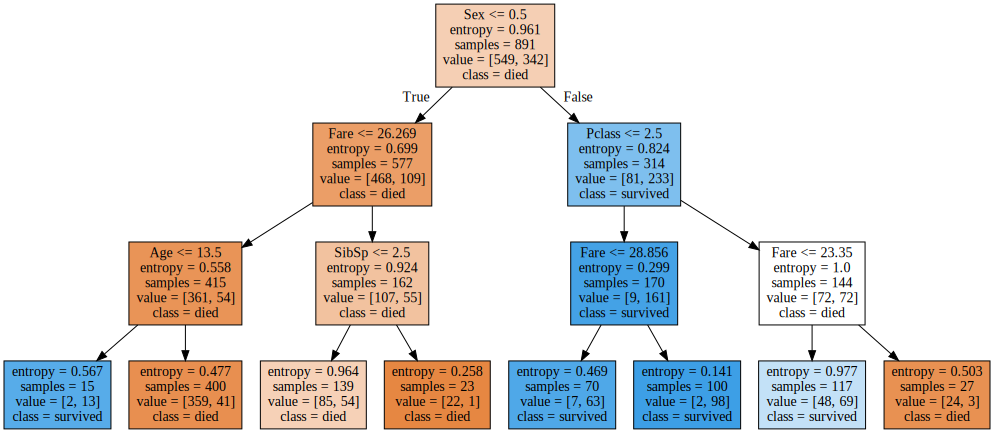

In [16]:
graph = Source(tree.export_graphviz(clf, out_file=None
   , feature_names=columns, class_names=['died', 'survived'] 
   , filled = True))
graph

In [17]:
### To open in seperate window and save it
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

According to the decision tree the main criterion (root node) for survival is the sex of the passenger (_if your implementation is correct so far_). In the left subtree are the male passengers (sex = 0), in the right subtree the female (sex=1). 

In the leafs the class information is given by a `value` array. Here the second value is the number of survivors in the leaves.

For example the leftmost leaf represents passengers that are male (sex=0) with fare<=26.2687 and age<=13.5. 13 of such boys survived and 2 of them died.

The entropy $- \sum p_i \log_2 (p_i)$ is displayed also at each node (splitting criterion).


### Prediction / Validation

To make predictions with scikit learn, we must convert the data in
the same way as we did it with the training data. Then we could use the method:    

    clf.predict(validation_data)
    
The depth of the decision tree is a hyperparameter. So the depth should be determined with the help of a 
validation set or by cross validation.

**Task:**

1. Manually split your training data in 75% for training and 25% for validation
2. Repeat the training process several times for different tree depths (define a new model every time)
3. Use `clf.predict(validation_data)` to predict your validation data
3. Manually calculate the accuracy for the validation set each time
 - Accuracy is defined as $\frac{\text{number of correct predictions}}{\text{number of all predictions}}$
4. From your results: Which seems to be the best tree depths?

In [18]:
### Exercise: Your code below to divide x and y
print(x.shape)
print(x[:int(x.shape[0]/4)].shape)
print(x[int(x.shape[0]/4):].shape)
x_train = x[:int(x.shape[0]/4)]
x_val = x[int(x.shape[0]/4):]

y_train = y[:int(x.shape[0]/4)]
y_val = y[int(x.shape[0]/4):]


(891, 5)
(222, 5)
(669, 5)


In [19]:
### Exercise: Your code below to train and predict trees with different depths

for depth in range(1,20):
    # Your code here
    clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=depth) # Exercise: Define and train the classifier
    clf_train = clf.fit(x_train,y_train)
    clf_predi = clf.predict(x_val)
    acc = (clf_predi - y_val) 
    acc = [1 if i == -1 else i for i in acc]
    acc = 1 - np.sum(acc) / len(y_val)
    print('depth: ', depth, ' acc: ', acc)

depth:  1  acc:  0.7802690582959642
depth:  2  acc:  0.7802690582959642
depth:  3  acc:  0.7847533632286996
depth:  4  acc:  0.8146487294469358
depth:  5  acc:  0.7907324364723468
depth:  6  acc:  0.7802690582959642
depth:  7  acc:  0.7877428998505231
depth:  8  acc:  0.7952167414050823
depth:  9  acc:  0.789237668161435
depth:  10  acc:  0.7847533632286996
depth:  11  acc:  0.7653213751868461
depth:  12  acc:  0.7713004484304933
depth:  13  acc:  0.7488789237668161
depth:  14  acc:  0.7698056801195815
depth:  15  acc:  0.7324364723467862
depth:  16  acc:  0.7608370702541106
depth:  17  acc:  0.7473841554559043
depth:  18  acc:  0.7548579970104634
depth:  19  acc:  0.7563527653213752


### Crossvalidation

Now with a dataset with less than 900 data examples (we have 891), chances to unluckily divide training and validation split seem pretty high. Also "wasting" 25% for validation on such a small data set is also not the ideal solution.

**Task:**

Now do not manually divide your data and do not manually compute the accuracy. Instead use the function `sklearn.model_selection.cross_val_score` to search the best tree depth. Use 10-fold crossvalidation.

In [20]:
### Exercise: Your code below for crossvalidation
depths = []
for depth in range(1,20):
    # Your code here
    clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=depth)
    scores = cross_val_score(estimator=clf, X=x, y=y, cv=10, n_jobs=-1, scoring="accuracy")
    depths.append((depth,scores.mean()))
for d in depths: print('depth: ', d[0], ' acc: ', d[1])

depth:  1  acc:  0.786729088639201
depth:  2  acc:  0.7688764044943821
depth:  3  acc:  0.8170536828963796
depth:  4  acc:  0.8081897627965045
depth:  5  acc:  0.8205368289637953
depth:  6  acc:  0.8194132334581774
depth:  7  acc:  0.8182771535580524
depth:  8  acc:  0.8127340823970037
depth:  9  acc:  0.8171535580524344
depth:  10  acc:  0.8126466916354558
depth:  11  acc:  0.8148564294631709
depth:  12  acc:  0.7991635455680399
depth:  13  acc:  0.8103995006242197
depth:  14  acc:  0.7969662921348315
depth:  15  acc:  0.7969662921348315
depth:  16  acc:  0.8014107365792758
depth:  17  acc:  0.792434456928839
depth:  18  acc:  0.7868414481897628
depth:  19  acc:  0.783458177278402


### Gridsearch

This already works pretty well to determine one hyperparameter. But imagine you had several hyperparameters. Since the computation (even with 10 fold crossvalidation) is very fast for decision trees, it is no problem at all to try out every possible combination of hyperparameters. For each hyperparameter you would have to implement another for-loop. Should be no problem. But for convenience, you should know scikit-learn also has a built-in function for that.

**Task:**

Use `sklearn.model_selection.GridSearchCV` to do a grid search for the best hyperparameters. In addition to `max_depth` parameter between _[1_, _20]_, add the `criterion` as another hyper parameter with the possible values _"entropy"_ and _"gini"_.

Further useful functions after the grid search: `clf.best_score_` and `clf.best_params_`

In [21]:
### Exercise: Your code below for grid search
parameters = {'max_depth':range(1,20), 'criterion':['entropy','gini']}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv=10)
clf.fit(X=x, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8227590511860174 {'criterion': 'entropy', 'max_depth': 5}


### Splitting Criterion Entropy / Information Gain

As you might have noticed, packages like _scikit learn_ can be very comfortable, since they do most of the work for you as long as you provide the data in the right format. Though a good advice is, that you should know what happens inside of such a black box.

**Task 1:**

Recompute the root node entropy. On Pen & paper or with just some lines of code here using basic mathematical operations.

In [22]:
# Code below
p = y.sum() / len(y)
entropy_before_split = - p * np.log2(p) - (1-p) * np.log2(1-p)
entropy_before_split

0.9607079018756469

In [23]:
np.testing.assert_almost_equal(entropy_before_split, 0.9607079018756469, decimal=5)

**Task 2:**

Compute the information gain of the first split node (root node). Use the shown entropy values and number of data records (samples). Again on Pen & paper or with just some lines of code here using basic mathematical operations.

In [24]:
# Code below

entropy_left = -(468/577 * np.log2(468/577) + 109/577 * np.log2(109/577))
entropy_right = -(81/314 * np.log2(81/314) + 233/314 * np.log2(233/314))
print("entropy left node:", entropy_left)
print("entropy right node:", entropy_right)

weighted_entropy_after_split = 577./(577+314) * entropy_left + 314./(577+314) * entropy_right

information_gain_split_root_node = entropy_before_split - weighted_entropy_after_split 

print("Information gain of the root node split:", information_gain_split_root_node)
len(y)-y.sum()

entropy left node: 0.6991817891208407
entropy right node: 0.8236550739295191
Information gain of the root node split: 0.2176601066606142


549

In [25]:
np.testing.assert_almost_equal(information_gain_split_root_node, 0.2176601066606142, decimal=5)

**Task 3:**

Compute the information gain of the following split table:

<table>
    <thead>
    <tr>
        <th>
        </th>
        <th>
            class 0
        </th>
        <th>
            class 1
        </th>
    </tr>
    </thead>
    <tr>
        <td>
            feature $\le$ v
        </td>
        <td>
            2
        </td>
        <td>
            13
        </td>
    </tr>
    <tr>
        <td>
            feature $>$ v
        </td>
        <td>
            359
        </td>
        <td>
            41
        </td>
    </tr>
</table>
 

The numbers are the corresponding data records, e.g. there are 13 data records with target class 1 and feature $\le$ v. 

Write a python function that computes the information gain.The data is given by a python array:

Like always, you are free to write as many helper functions as you want.

In [26]:
data = np.array([[2.,13.],
                [359., 41.]])

In [119]:
def entropy(subset, myset):
    subset=subset[0]
    notsubset = myset - subset
    entropy = - (subset/myset * np.log2(subset/myset) + notsubset/myset * np.log2(notsubset/myset))
    #print("Set:",myset,subset, notsubset)
    #print("Entropy:",entropy)
    return entropy

def information_gain(data):
    c0c1 = data.sum(axis=0)
    allsum = data.sum()
    sv = data[0]            #smaller v
    svsum = data[0].sum()
    bv = data[1]            #bigger v
    bvsum = data[1].sum()

    entropy_before_split = entropy(c0c1,allsum)
    entropy_feature_smaller_v = entropy(sv,svsum)
    entropy_feature_bigger_v = entropy(bv,bvsum)
    #print(entropy_feature_smaller_v)
    #print(entropy_feature_bigger_v)
    #weights = data.sum(axis=1) / allsum
    weighted_entropy_after_split = (data[0].sum() / allsum) * entropy_feature_smaller_v + (data[1].sum() / allsum) * entropy_feature_bigger_v
    return entropy_before_split - weighted_entropy_after_split

In [118]:
np.testing.assert_almost_equal(information_gain(data), 0.07765787804281093)
print("Information Gain:", information_gain(data))

Information Gain: 0.07765787804281093


## Summary and Outlook

Machine learning is not exclusively about neural networks - In this notebook you implemented a decision tree, which chains a set of if-then-else decision rules to make a prediction. You employed two popular APIs, scikit-learn and pandas. You also calculated entropy and information gain, measures that are widely applicable in a host of statistics tasks.

## Literature

<table>
    <tr>
        <td>
            <a name="CRI"></a>[CRI]
        </td>
        <td>
            A. Criminisi, J. Shotton, and E. Konukoglu, Decision Forests for Classification, Regression, Density Estimation, Manifold Learning and Semi- Supervised Learning, no. MSR-TR-2011-114, 28 October 2011. - http://research.microsoft.com/pubs/155552/decisionForests_MSR_TR_2011_114.pdf
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Logistic Regression and Regularization <br/>
by Christian Herta, Klaus Strohmenger<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.